In [1]:
import os
from pathlib import Path
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.stats.api as sms
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Input data

In [2]:
cwd = os.getcwd()
root_dir = Path(cwd).parent

In [3]:
# SET INPUTs & DIRECTORIES

# Individual data
data_IND_tot = pd.read_csv(path.join(root_dir,
                                    "data/raw/individual_data.csv"))

# Household data
data_HH_tot = pd.read_csv(path.join(root_dir,
                                    "data/raw/household_data.csv"))

# 2. Preprocess data

## 2.2. Set key exposure variables

In [4]:
## Set exposure variables necessary for analysis: water facilities' characteristics + potential confounders

# Dummy dataframe
df = data_HH_tot.copy()


## Outcome of interest

# Water availability in the past month (self-reported)
wt_avail_mask = (df["DrinkingWaterAvailability"]=='N') # no lack of water in the previous month
df["AvailblWtM"] = np.nan
df["AvailblWtM"][~df["DrinkingWaterAvailability"].isna()] = 0
df["AvailblWtM"][wt_avail_mask] = 1


## Water services

# Recode access to "basic water" (following JMP definition) VS any other service type (including unimproved)
wt_basic_mask = (((df["DrinkingWaterGroup"]=='Private')&
                  (df["DrinkingWater_Private"].isin(['Piped_dwel','Piped_yard'])))|
                 ((df["DrinkingWaterGroup"]=='Private')&
                  (df["DrinkingWater_Private"].isin(['Piped_neigh']))&
                  (df["DrinkingWaterDist"]<=30))|
                 ((df["DrinkingWaterGroup"]=='Public')&
                  (df["DrinkingWater_Public"].isin(['Public_Tap','Vendor','Public_Dispenser','Ground_tube']))&
                  (df["DrinkingWaterDist"]<=30)))
df["BasicWt"] = np.nan
df["BasicWt"][(~df["DrinkingWaterGroup"].isna())] = 0
df["BasicWt"][wt_basic_mask] = 1

# Recode access to water piped to premises VS any other service type (including unimproved)
wt_piped_mask = (df["DrinkingWater_Private"].isin(['Piped_dwel','Piped_yard'])) # water piped to own dwelling or yard
df["PipedWt"] = np.nan
df["PipedWt"][(~df["DrinkingWaterGroup"].isna())] = 0
df["PipedWt"][wt_piped_mask] = 1

# Recode access to piped water from neighbor VS any other service type (including unimproved)
wt_pipnb_mask = ((df["DrinkingWater_Private"].isin(['Piped_neigh']))&
                 (df["DrinkingWaterDist"]<=30)) # water piped to a neighbor's dwelling or yard
df["PipNbWt"] = np.nan
df["PipNbWt"][(~df["DrinkingWaterGroup"].isna())] = 0
df["PipNbWt"][wt_pipnb_mask] = 1

# Recode use of water from public water taps/dispensers VS any other service type (including unimproved)
wt_pubtp_mask = ((df["DrinkingWater_Public"].isin(['Public_Tap','Public_Dispenser']))&
                 (df["DrinkingWaterDist"]<=30)) # water from public tap or dispenser ('kiosk'/'ATM')
df["PbTapWt"] = np.nan
df["PbTapWt"][(~df["DrinkingWaterGroup"].isna())] = 0
df["PbTapWt"][wt_pubtp_mask] = 1

# Recode use of water from commercial source (in a public location) VS any other service type (including unimproved)
wt_cmsrc_mask = ((df["DrinkingWater_Public"]=='Vendor')&
                 (df["DrinkingWaterDist"]<=30)) # water mainly obtained from street vendors
df["CmSrcWt"] = np.nan
df["CmSrcWt"][(~df["DrinkingWaterGroup"].isna())] = 0
df["CmSrcWt"][wt_cmsrc_mask] = 1

# Recode use of water from street vendors VS any other service type (including unimproved)
wt_stven_mask = ((df["DrinkingWater_Public"]=='Vendor')&
                 (df["DrinkingWater_PublicVendor"].isin(['Vendor_Cart', 'Vendor_Bottled', 'Vendor_Sachet']))&
                 (df["DrinkingWaterDist"]<=30)) # water mainly obtained from street vendors
df["StVenWt"] = np.nan
df["StVenWt"][(~df["DrinkingWaterGroup"].isna())] = 0
df["StVenWt"][wt_stven_mask] = 1


## Housing conditions

# Recode overcrowding (whether number of habitants per room > 3, following 'slum' definition in SDG 11)
src = data_IND_tot.copy()
hab_cnt_df = src[['KEY','PARENT_KEY']].groupby('PARENT_KEY').count().reset_index() # count habitants per household
hab_cnt_df = hab_cnt_df.rename(columns={"KEY": "Cnt_Hab"})
hab_cnt_df = hab_cnt_df.rename(columns={"PARENT_KEY": "KEY"})
df = df.merge(hab_cnt_df,how='left',on='KEY') # join variable with count of houshehold members
df['HHROOMS'][df['HHROOMS'].isin([111,999])] = np.nan # exclude invalid answers & outliers regarding rooms
df['HabPerRoom'] = df['Cnt_Hab']/df['HHROOMS']
hiden_mask = (df["HabPerRoom"]>3) # high density if number of household members per room > 3
df["HiDensity"] = np.nan
df["HiDensity"][~df["HabPerRoom"].isna()] = 0
df["HiDensity"][hiden_mask] = 1


## Potential confounders

# Wealth based on households assets
df["ItemsScore"]=(df["HHITEMS/Computer"]+df["HHITEMS/Electricity"]+
                  df["HHITEMS/Internet"]+df["HHITEMS/Microwave"]+
                  df["HHITEMS/Oven"]+df["HHITEMS/Radio"]+
                  df["HHITEMS/Refrigerator"]+df["HHITEMS/Smartphone"]+
                  df["HHITEMS/Television"])
df["ItemsScore"][(df["HHITEMS/Noitems"]==1)] = 0
df["ItemsScore"][(df["HHITEMS/NA"]==1)] = np.nan
wealth_mask = (df["ItemsScore"]>df["ItemsScore"].mean())# Number of items above the mean (of the surveyed households)
df["WealthyHH"] = np.nan
df["WealthyHH"][~df["ItemsScore"].isna()] = 0
df["WealthyHH"][wealth_mask] = 1

# Education level of heads of households
src = data_IND_tot[data_IND_tot.Relation_to_HH=='Head'][['PARENT_KEY',
                                                         'School_past']]# subset ed. level of HH
# Recode education level of heads of households
src['SecEduHH'] = np.nan
src['SecEduHH'][src['School_past'].isin(['No_Edu',
                                         'Early_CdE',
                                         'Primary'])] = 0 # up to primary education
src['SecEduHH'][src['School_past'].isin(['Secondary',
                                         'High_Ed'])] = 1 # secondary or higher education
src = src[~src.SecEduHH.isna()]
# In case a same household has 2 heads, merge lines
src = src[['SecEduHH','PARENT_KEY']].groupby(by="PARENT_KEY").max().reset_index()
src = src.rename(columns={"PARENT_KEY": "KEY"})
# Attribute education level of heads of households
df = df.merge(src,on="KEY",how='left')

# 3. Odds ratios

## 3.1. Associations between water sources and water availability in the month preceding the survey (adjusted by wealth, education and density) 
Note: in this step, we stratify the logistic regressions by type of water source for they are mutually exclusive (while adjusting by other relevant covariates)

### 3.1.1. Unadjusted odds ratios

In [5]:
# Exposure variables list
outcome = 'AvailblWtM'
exposure_list = ['PipedWt','PipNbWt','PbTapWt','CmSrcWt','StVenWt']

# Control variables list
control_list = []

# Create OR dataframe (initially empty)
or_wtavar_unadj = pd.DataFrame()

# Discard exposure variable if all observations are exposed, or non-exposed (OR not plausible)
drop_list = []
print('==============================================================================')
print('                         CHECKING EXPOSURE VARIABLES:')
print('')
for var in exposure_list:
    if len(df[var].value_counts().values)==1:
        drop_list = drop_list+[var]
        print('>> WARNING : dropped',var,'( only 0s or 1s )')
if len(drop_list)==0:
    print('>> All good!')
elif len(drop_list)>0:
    exposure_list = sorted(list(set(exposure_list)-set(drop_list))) # update exposure variables list if needed
print('==============================================================================')

# Run logistic regressions for each source individually
for exposure in exposure_list:
    
    # Set exposure list
    if exposure in control_list:
        var_list = list(set(control_list)-set([exposure]))+[exposure]
    else:
        var_list = control_list+[exposure]
    
    # Data and logistic model
    data_reg = df[[outcome]+var_list].copy()
    data_reg = data_reg.dropna()
    logit = sm.Logit(data_reg[outcome], sm.add_constant(data_reg[var_list]))
    result = logit.fit()
    
    # Print the source type
    print('==============================================================================')
    print('                              Variable:',exposure)
    
    # Print the summary of the model
    print(result.summary())
    
    # Calculate the odds ratios and confidence intervals
    params = result.params
    conf = result.conf_int()
    signif = result.pvalues
    modelpval = result.llr_pvalue
    odds_ratios = np.exp(params)
    conf_lower = np.exp(conf[0])
    conf_upper = np.exp(conf[1])

    # Print the odds ratios and confidence intervals
    or_strat = pd.DataFrame({'OR': odds_ratios,
                             'signif': signif,
                             'Lower CI': conf_lower,
                             'Upper CI': conf_upper}).reset_index()
    or_strat['Significance'] = ''
    if modelpval < 0.05:
        or_strat['Significance'][or_strat['signif']>=0.1] = 'Not significant'
        or_strat['Significance'][or_strat['signif']<0.1] = '*'
        or_strat['Significance'][or_strat['signif']<0.05] = '**'
        or_strat['Significance'][or_strat['signif']<0.01] = '***'
        or_strat['Significance'][or_strat['signif']<0.001] = '****'
    else:
        or_strat['Significance'] = 'Not significant (LLR p-value > 5%)'
    or_strat = or_strat.drop(['signif'],axis=1)
    or_strat.columns = ['Exposure','Unadjusted OR','Lower CI (95%)','Upper CI (95%)','Significance']
    or_strat = or_strat.iloc[1:]
    or_wtavar_unadj = pd.concat([or_wtavar_unadj,
                                 or_strat[or_strat['Exposure']==exposure]],
                                ignore_index=True)
    or_wtavar_unadj = or_wtavar_unadj.replace({'Exposure':{'PipedWt':'Water piped to premises',
                                                           'PipNbWt':'Water obtained from neighbor (piped)',
                                                           'PbTapWt':'Water obtained from public tap',
                                                           'CmSrcWt':'Water obtained from a commercial source (vendor or boozer)',
                                                           'StVenWt':'Water obtained from street vendor',
                                                          }})
    
# View adjusted ORs for each source
or_wtavar_unadj

                         CHECKING EXPOSURE VARIABLES:

>> All good!
Optimization terminated successfully.
         Current function value: 0.656593
         Iterations 4
                              Variable: PipedWt
                           Logit Regression Results                           
Dep. Variable:             AvailblWtM   No. Observations:                 1143
Model:                          Logit   Df Residuals:                     1141
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Jun 2024   Pseudo R-squ.:               5.639e-05
Time:                        13:06:05   Log-Likelihood:                -750.49
converged:                       True   LL-Null:                       -750.53
Covariance Type:            nonrobust   LLR p-value:                    0.7711
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

,Exposure,Unadjusted OR,Lower CI (95%),Upper CI (95%),Significance
0,Water piped to premises,0.935804,0.597775,1.464980,Not significant (LLR p-value > 5%)
1,Water obtained from neighbor (piped),0.423932,0.274207,0.655411,****
2,Water obtained from public tap,1.223444,0.920876,1.625425,Not significant (LLR p-value > 5%)
3,Water obtained from a commercial source (vendo...,3.673575,1.990487,6.779826,****
4,Water obtained from street vendor,12.941026,4.506581,37.161240,****


### 3.1.2. Adjusted odds ratios

In [6]:
# Exposure variables list
outcome = 'AvailblWtM'
exposure_list = ['PipedWt','PipNbWt','PbTapWt','CmSrcWt','StVenWt']

# Control variables list
control_list = ['HiDensity','WealthyHH','SecEduHH']

# Create OR dataframe (initially empty)
or_wtavar_final = pd.DataFrame()

# Discard exposure variable if all observations are exposed, or non-exposed (OR not plausible)
drop_list = []
print('==============================================================================')
print('                         CHECKING EXPOSURE VARIABLES:')
print('')
for var in exposure_list:
    if len(df[var].value_counts().values)==1:
        drop_list = drop_list+[var]
        print('>> WARNING : dropped',var,'( only 0s or 1s )')
if len(drop_list)==0:
    print('>> All good!')
elif len(drop_list)>0:
    exposure_list = sorted(list(set(exposure_list)-set(drop_list))) # update exposure variables list if needed
print('==============================================================================')

# Run logistic regressions for each source individually
for exposure in exposure_list:
    
    # Set exposure list
    if exposure in control_list:
        var_list = list(set(control_list)-set([exposure]))+[exposure]
    else:
        var_list = control_list+[exposure]
    
    # Data and logistic model
    data_reg = df[[outcome]+var_list].copy()
    data_reg = data_reg.dropna()
    logit = sm.Logit(data_reg[outcome], sm.add_constant(data_reg[var_list]))
    result = logit.fit()
    
    # Print the source type
    print('==============================================================================')
    print('                              Variable:',exposure)
    
    # Print the summary of the model
    print(result.summary())
    
    # Calculate the odds ratios and confidence intervals
    params = result.params
    conf = result.conf_int()
    signif = result.pvalues
    modelpval = result.llr_pvalue
    odds_ratios = np.exp(params)
    conf_lower = np.exp(conf[0])
    conf_upper = np.exp(conf[1])

    # Print the odds ratios and confidence intervals
    or_strat = pd.DataFrame({'OR': odds_ratios,
                             'signif': signif,
                             'Lower CI': conf_lower,
                             'Upper CI': conf_upper}).reset_index()
    or_strat['Significance'] = ''
    if modelpval < 0.05:
        or_strat['Significance'][or_strat['signif']>=0.1] = 'Not significant'
        or_strat['Significance'][or_strat['signif']<0.1] = '*'
        or_strat['Significance'][or_strat['signif']<0.05] = '**'
        or_strat['Significance'][or_strat['signif']<0.01] = '***'
        or_strat['Significance'][or_strat['signif']<0.001] = '****'
    else:
        or_strat['Significance'] = 'Not significant (LLR p-value > 5%)'
    or_strat = or_strat.drop(['signif'],axis=1)
    or_strat.columns = ['Exposure','Adjusted OR','Lower CI (95%)','Upper CI (95%)','Significance']
    or_strat = or_strat.iloc[1:]
    or_wtavar_final = pd.concat([or_wtavar_final,
                                 or_strat[or_strat['Exposure']==exposure]],
                                ignore_index=True)
    or_wtavar_final = or_wtavar_final.replace({'Exposure':{'PipedWt':'Water piped to premises',
                                                           'PipNbWt':'Water obtained from neighbor (piped)',
                                                           'PbTapWt':'Water obtained from public tap',
                                                           'CmSrcWt':'Water obtained from a commercial source (vendor or boozer)',
                                                           'StVenWt':'Water obtained from street vendor',
                                                          }})
    
# View adjusted ORs for each source
or_wtavar_final

                         CHECKING EXPOSURE VARIABLES:

>> All good!
Optimization terminated successfully.
         Current function value: 0.638399
         Iterations 5
                              Variable: PipedWt
                           Logit Regression Results                           
Dep. Variable:             AvailblWtM   No. Observations:                 1027
Model:                          Logit   Df Residuals:                     1022
Method:                           MLE   Df Model:                            4
Date:                Mon, 24 Jun 2024   Pseudo R-squ.:                0.005925
Time:                        13:06:05   Log-Likelihood:                -655.64
converged:                       True   LL-Null:                       -659.54
Covariance Type:            nonrobust   LLR p-value:                   0.09855
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

,Exposure,Adjusted OR,Lower CI (95%),Upper CI (95%),Significance
0,Water piped to premises,0.959153,0.595031,1.546096,Not significant (LLR p-value > 5%)
1,Water obtained from neighbor (piped),0.445696,0.282079,0.704217,****
2,Water obtained from public tap,1.453405,1.059167,1.994385,**
3,Water obtained from a commercial source (vendo...,2.050760,0.975664,4.310518,*
4,Water obtained from street vendor,11.162022,2.451555,50.821104,***


In [7]:
# Set VIF threshold
vif_t = 5

for var in exposure_list:
    print("------------------------ ",var," ------------------------")
    # Dummy dataframes: keep only observations with valid answers for all selected variables
    dataset = df[control_list+[var]].copy().dropna()

    # Create table for Variance Inflation Factor (VIF)
    vif_scores = pd.DataFrame() 
    vif_scores["Attribute"] = control_list+[var]

    # Calculate VIF for each feature
    vif_var = "VIF Scores"
    vif_scores[vif_var] = [variance_inflation_factor(dataset[control_list+[var]].values, i) for i in range(len(dataset[control_list+[var]].columns))] 

    # Assess variables' VIF
    if vif_scores[vif_var].max() < vif_t:
        print("All good: no significant multicollinearity")
    else:
        drop_v_list = vif_scores["Attribute"][vif_scores[vif_var]>vif_t].to_list()
        print(">> WARNING: multicollinearity detected for:",
              drop_v_list)
        for var in drop_v_list:
            print(str(round(dataset[var].mean(),4)*100)+
                  "% of individuals in selected households had a positive outcome for",
                  '"',var,'"')

    # View results
    display(vif_scores)

------------------------  PipedWt  ------------------------
All good: no significant multicollinearity


,Attribute,VIF Scores
0,HiDensity,1.284940
1,WealthyHH,1.746011
2,SecEduHH,1.552275
3,PipedWt,1.095445


------------------------  PipNbWt  ------------------------
All good: no significant multicollinearity


,Attribute,VIF Scores
0,HiDensity,1.280853
1,WealthyHH,1.717706
2,SecEduHH,1.608339
3,PipNbWt,1.096693


------------------------  PbTapWt  ------------------------
All good: no significant multicollinearity


,Attribute,VIF Scores
0,HiDensity,1.447028
1,WealthyHH,1.910013
2,SecEduHH,1.753352
3,PbTapWt,2.114042


------------------------  CmSrcWt  ------------------------
All good: no significant multicollinearity


,Attribute,VIF Scores
0,HiDensity,1.279008
1,WealthyHH,1.718192
2,SecEduHH,1.551437
3,CmSrcWt,1.024948


------------------------  StVenWt  ------------------------
All good: no significant multicollinearity


,Attribute,VIF Scores
0,HiDensity,1.280358
1,WealthyHH,1.716351
2,SecEduHH,1.540714
3,StVenWt,1.006574


# 4. Supplementary analyses

## 4.1. Associations between overcrowding and lack of water

### 4.1.1. Unadjusted odds ratios

In [8]:
# Exposure variables list
outcome = 'HiDensity'
exposure_list = ['AvailblWtM']

# Control variables list
control_list = []

# Create OR dataframe (initially empty)
or_wtavar_dens_unadj = pd.DataFrame()

# Discard exposure variable if all observations are exposed, or non-exposed (OR not plausible)
drop_list = []
print('==============================================================================')
print('                         CHECKING EXPOSURE VARIABLES:')
print('')
for var in exposure_list:
    if len(df[var].value_counts().values)==1:
        drop_list = drop_list+[var]
        print('>> WARNING : dropped',var,'( only 0s or 1s )')
if len(drop_list)==0:
    print('>> All good!')
elif len(drop_list)>0:
    exposure_list = sorted(list(set(exposure_list)-set(drop_list))) # update exposure variables list if needed
print('==============================================================================')

# Run logistic regressions for each source individually
for exposure in exposure_list:
    
    # Set exposure list
    if exposure in control_list:
        var_list = list(set(control_list)-set([exposure]))+[exposure]
    else:
        var_list = control_list+[exposure]
    
    # Data and logistic model
    data_reg = df[[outcome]+var_list].copy()
    data_reg = data_reg.dropna()
    logit = sm.Logit(data_reg[outcome], sm.add_constant(data_reg[var_list]))
    result = logit.fit()
    
    # Print the source type
    print('==============================================================================')
    print('                              Variable:',exposure)
    
    # Print the summary of the model
    print(result.summary())
    
    # Calculate the odds ratios and confidence intervals
    params = result.params
    conf = result.conf_int()
    signif = result.pvalues
    modelpval = result.llr_pvalue
    odds_ratios = np.exp(params)
    conf_lower = np.exp(conf[0])
    conf_upper = np.exp(conf[1])

    # Print the odds ratios and confidence intervals
    or_strat = pd.DataFrame({'OR': odds_ratios,
                             'signif': signif,
                             'Lower CI': conf_lower,
                             'Upper CI': conf_upper}).reset_index()
    or_strat['Significance'] = ''
    if modelpval < 0.05:
        or_strat['Significance'][or_strat['signif']>=0.1] = 'Not significant'
        or_strat['Significance'][or_strat['signif']<0.1] = '*'
        or_strat['Significance'][or_strat['signif']<0.05] = '**'
        or_strat['Significance'][or_strat['signif']<0.01] = '***'
        or_strat['Significance'][or_strat['signif']<0.001] = '****'
    else:
        or_strat['Significance'] = 'Not significant (LLR p-value > 5%)'
    or_strat = or_strat.drop(['signif'],axis=1)
    or_strat.columns = ['Exposure','Unadjusted OR','Lower CI (95%)','Upper CI (95%)','Significance']
    or_strat = or_strat.iloc[1:]
    or_wtavar_dens_unadj = pd.concat([or_wtavar_dens_unadj,
                                      or_strat[or_strat['Exposure']==exposure]],
                                     ignore_index=True)
    or_wtavar_dens_unadj = or_wtavar_dens_unadj.replace({'Exposure':{'AvailblWtM':'Water availability',
                                                           'HandHyg':'Hand hygiene'
                                                          }})
    
# View adjusted ORs for each source
or_wtavar_dens_unadj

                         CHECKING EXPOSURE VARIABLES:

>> All good!
Optimization terminated successfully.
         Current function value: 0.646315
         Iterations 5
                              Variable: AvailblWtM
                           Logit Regression Results                           
Dep. Variable:              HiDensity   No. Observations:                 1137
Model:                          Logit   Df Residuals:                     1135
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Jun 2024   Pseudo R-squ.:                0.004277
Time:                        13:06:05   Log-Likelihood:                -734.86
converged:                       True   LL-Null:                       -738.02
Covariance Type:            nonrobust   LLR p-value:                   0.01198
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

,Exposure,Unadjusted OR,Lower CI (95%),Upper CI (95%),Significance
0,Water availability,0.721081,0.557777,0.932197,**


### 4.1.2. Adjusted odds ratios

In [9]:
# Exposure variables list
outcome = 'HiDensity'
exposure_list = ['AvailblWtM']

# Control variables list
control_list = ['WealthyHH','SecEduHH']

# Create OR dataframe (initially empty)
or_wtavar_dens = pd.DataFrame()

# Discard exposure variable if all observations are exposed, or non-exposed (OR not plausible)
drop_list = []
print('==============================================================================')
print('                         CHECKING EXPOSURE VARIABLES:')
print('')
for var in exposure_list:
    if len(df[var].value_counts().values)==1:
        drop_list = drop_list+[var]
        print('>> WARNING : dropped',var,'( only 0s or 1s )')
if len(drop_list)==0:
    print('>> All good!')
elif len(drop_list)>0:
    exposure_list = sorted(list(set(exposure_list)-set(drop_list))) # update exposure variables list if needed
print('==============================================================================')

# Run logistic regressions for each source individually
for exposure in exposure_list:
    
    # Set exposure list
    if exposure in control_list:
        var_list = list(set(control_list)-set([exposure]))+[exposure]
    else:
        var_list = control_list+[exposure]
    
    # Data and logistic model
    data_reg = df[[outcome]+var_list].copy()
    data_reg = data_reg.dropna()
    logit = sm.Logit(data_reg[outcome], sm.add_constant(data_reg[var_list]))
    result = logit.fit()
    
    # Print the source type
    print('==============================================================================')
    print('                              Variable:',exposure)
    
    # Print the summary of the model
    print(result.summary())
    
    # Calculate the odds ratios and confidence intervals
    params = result.params
    conf = result.conf_int()
    signif = result.pvalues
    modelpval = result.llr_pvalue
    odds_ratios = np.exp(params)
    conf_lower = np.exp(conf[0])
    conf_upper = np.exp(conf[1])

    # Print the odds ratios and confidence intervals
    or_strat = pd.DataFrame({'OR': odds_ratios,
                             'signif': signif,
                             'Lower CI': conf_lower,
                             'Upper CI': conf_upper}).reset_index()
    or_strat['Significance'] = ''
    if modelpval < 0.05:
        or_strat['Significance'][or_strat['signif']>=0.1] = 'Not significant'
        or_strat['Significance'][or_strat['signif']<0.1] = '*'
        or_strat['Significance'][or_strat['signif']<0.05] = '**'
        or_strat['Significance'][or_strat['signif']<0.01] = '***'
        or_strat['Significance'][or_strat['signif']<0.001] = '****'
    else:
        or_strat['Significance'] = 'Not significant (LLR p-value > 5%)'
    or_strat = or_strat.drop(['signif'],axis=1)
    or_strat.columns = ['Exposure','Adjusted OR','Lower CI (95%)','Upper CI (95%)','Significance']
    or_strat = or_strat.iloc[1:]
    or_wtavar_dens = pd.concat([or_wtavar_dens,
                                or_strat[or_strat['Exposure']==exposure]],
                               ignore_index=True)
    or_wtavar_dens = or_wtavar_dens.replace({'Exposure':{'AvailblWtM':'Water availability',
                                                           'HandHyg':'Hand hygiene'
                                                          }})
    
# View adjusted ORs for each source
or_wtavar_dens

                         CHECKING EXPOSURE VARIABLES:

>> All good!
Optimization terminated successfully.
         Current function value: 0.625531
         Iterations 5
                              Variable: AvailblWtM
                           Logit Regression Results                           
Dep. Variable:              HiDensity   No. Observations:                 1029
Model:                          Logit   Df Residuals:                     1025
Method:                           MLE   Df Model:                            3
Date:                Mon, 24 Jun 2024   Pseudo R-squ.:                 0.02818
Time:                        13:06:05   Log-Likelihood:                -643.67
converged:                       True   LL-Null:                       -662.33
Covariance Type:            nonrobust   LLR p-value:                 3.925e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

,Exposure,Adjusted OR,Lower CI (95%),Upper CI (95%),Significance
0,Water availability,0.688551,0.519347,0.912882,***


In [10]:
# Set VIF threshold
vif_t = 5

# Dummy dataframes: keep only observations with valid answers for all selected variables
dataset = df[control_list+exposure_list].copy().dropna()

# Create table for Variance Inflation Factor (VIF)
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = control_list+exposure_list

# Calculate VIF for each feature
vif_var = "VIF Scores"
vif_scores[vif_var] = [variance_inflation_factor(dataset[control_list+exposure_list].values, i) for i in range(len(dataset[control_list+exposure_list].columns))] 

# Assess variables' VIF
if vif_scores[vif_var].max() < vif_t:
    print("All good: no significant multicollinearity")
else:
    drop_v_list = vif_scores["Attribute"][vif_scores[vif_var]>vif_t].to_list()
    print(">> WARNING: multicollinearity detected for:",
          drop_v_list)
    for var in drop_v_list:
        print(str(round(dataset[var].mean(),4)*100)+
              "% of individuals in selected households had a positive outcome for",
              '"',var,'"')
        
# View results
display(vif_scores)

All good: no significant multicollinearity


,Attribute,VIF Scores
0,WealthyHH,1.603292
1,SecEduHH,1.630996
2,AvailblWtM,1.308012


## 4.2. Descriptive statistics

### 4.2.1. Access water services (% of participating households), by distribution type

In [11]:
## All valid household surveys

# Dummy dataframe
df_c = df.copy()

In [12]:
## Number of households

# Both sites
tot_hh = len(df_c.KEY.unique())

# Mathare
tot_hh_mat = len(df_c[df_c['Site']=='Mathare'].KEY.unique())

# Mukuru
tot_hh_muk = len(df_c[df_c['Site']=='Mukuru'].KEY.unique())

# Print stats
print('Total households:',tot_hh)
print('----------------------------------------')
print('Total households in Mathare:',tot_hh_mat)
print('----------------------------------------')
print('Total households in Mukuru:',tot_hh_muk)

Total households: 1147
----------------------------------------
Total households in Mathare: 576
----------------------------------------
Total households in Mukuru: 571


In [13]:
## Lack of water, by site

# Common denominator (total number of households where key variable is not NA)
den_hh_lackwt = df[~df['AvailblWtM'].isna()].shape[0]
den_hh_lackwt_mat = df[(~df['AvailblWtM'].isna())&(df['Site']=='Mathare')].shape[0]
den_hh_lackwt_muk = df[(~df['AvailblWtM'].isna())&(df['Site']=='Mukuru')].shape[0]

# Both sites
tot_hh_lackwt = df[df['AvailblWtM']==0].shape[0]
tot_hh_wtok = df[df['AvailblWtM']==1].shape[0]

# Mathare
tot_hh_mat_lackwt = df[(df['AvailblWtM']==0)&(df['Site']=='Mathare')].shape[0]
tot_hh_mat_wtok = df[(df['AvailblWtM']==1)&(df['Site']=='Mathare')].shape[0]

# Mukuru
tot_hh_muk_lackwt = df[(df['AvailblWtM']==0)&(df['Site']=='Mukuru')].shape[0]
tot_hh_muk_wtok = df[(df['AvailblWtM']==1)&(df['Site']=='Mukuru')].shape[0]


## Print stats

# Both sites
P = (tot_hh_lackwt/den_hh_lackwt)
N = den_hh_lackwt
CI = 1.96*(np.sqrt((P*(1-P))/N))
print('Households having lacked water in the month preceding the survey (both sites):\n',
      tot_hh_lackwt,'(',round(P*100,2),'% ; 95% CI:',round(((P-CI)*100),2),'-',round(((P+CI)*100),2),'% )')
# Mathare
P = (tot_hh_mat_lackwt/den_hh_lackwt_mat)
N = den_hh_lackwt_mat
CI = 1.96*(np.sqrt((P*(1-P))/N))
print('Households having lacked water in the month preceding the survey in Mathare:\n',
      tot_hh_mat_lackwt,'(',round(P*100,2),'% ; 95% CI:',round(((P-CI)*100),2),'-',round(((P+CI)*100),2),'% )')
# Mukuru
P = (tot_hh_muk_lackwt/den_hh_lackwt_muk)
N = den_hh_lackwt_muk
CI = 1.96*(np.sqrt((P*(1-P))/N))
print('Households having lacked water in the month preceding the survey in Mukuru:\n',
      tot_hh_muk_lackwt,'(',round(P*100,2),'% ; 95% CI:',round(((P-CI)*100),2),'-',round(((P+CI)*100),2),'% )')

Households having lacked water in the month preceding the survey (both sites):
 725 ( 63.32 % ; 95% CI: 60.53 - 66.11 % )
Households having lacked water in the month preceding the survey in Mathare:
 387 ( 67.3 % ; 95% CI: 63.47 - 71.14 % )
Households having lacked water in the month preceding the survey in Mukuru:
 338 ( 59.3 % ; 95% CI: 55.27 - 63.33 % )


In [14]:
## Access to water services, by type and site

# Both sites
tot_hh_basic = df[df['BasicWt']==1].shape[0]
tot_hh_piped = df[df['PipedWt']==1].shape[0]
tot_hh_pipnb = df[df['PipNbWt']==1].shape[0]
tot_hh_pbtap = df[df['PbTapWt']==1].shape[0]
tot_hh_cmsrc = df[df['CmSrcWt']==1].shape[0]
tot_hh_stven = df[df['StVenWt']==1].shape[0]

# Mathare
tot_hh_mat_basic = df[(df['BasicWt']==1)&(df['Site']=='Mathare')].shape[0]
tot_hh_mat_piped = df[(df['PipedWt']==1)&(df['Site']=='Mathare')].shape[0]
tot_hh_mat_pipnb = df[(df['PipNbWt']==1)&(df['Site']=='Mathare')].shape[0]
tot_hh_mat_pbtap = df[(df['PbTapWt']==1)&(df['Site']=='Mathare')].shape[0]
tot_hh_mat_cmsrc = df[(df['CmSrcWt']==1)&(df['Site']=='Mathare')].shape[0]
tot_hh_mat_stven = df[(df['StVenWt']==1)&(df['Site']=='Mathare')].shape[0]

# Mukuru
tot_hh_muk_basic = df[(df['BasicWt']==1)&(df['Site']=='Mukuru')].shape[0]
tot_hh_muk_piped = df[(df['PipedWt']==1)&(df['Site']=='Mukuru')].shape[0]
tot_hh_muk_pipnb = df[(df['PipNbWt']==1)&(df['Site']=='Mukuru')].shape[0]
tot_hh_muk_pbtap = df[(df['PbTapWt']==1)&(df['Site']=='Mukuru')].shape[0]
tot_hh_muk_cmsrc = df[(df['CmSrcWt']==1)&(df['Site']=='Mukuru')].shape[0]
tot_hh_muk_stven = df[(df['StVenWt']==1)&(df['Site']=='Mukuru')].shape[0]

# Print stats
print('Households with acess to "basic" water (both sites):',tot_hh_basic,
      '(',round((tot_hh_basic/tot_hh)*100,2),'% )')
print('Households with acess to "basic" water in Mathare:',tot_hh_mat_basic,
      '(',round((tot_hh_mat_basic/tot_hh_mat)*100,2),'% )')
print('Households with acess to "basic" water in Mukuru:',tot_hh_muk_basic,
      '(',round((tot_hh_muk_basic/tot_hh_muk)*100,2),'% )')
print('----------------------------------------')
print('Households using mostly water piped to premises (both sites):',tot_hh_piped,
      '(',round((tot_hh_piped/tot_hh)*100,2),'% )')
print('Households using mostly water piped to premises in Mathare:',tot_hh_mat_piped,
      '(',round((tot_hh_mat_piped/tot_hh_mat)*100,2),'% )')
print('Households using mostly water piped to premises in Mukuru:',tot_hh_muk_piped,
      '(',round((tot_hh_muk_piped/tot_hh_muk)*100,2),'% )')
print('----------------------------------------')
print('Households using mostly water piped to a neighboring dwelling (both sites):',tot_hh_pipnb,
      '(',round((tot_hh_pipnb/tot_hh)*100,2),'% )')
print('Households using mostly water piped to a neighboring dwelling in Mathare:',tot_hh_mat_pipnb,
      '(',round((tot_hh_mat_pipnb/tot_hh_mat)*100,2),'% )')
print('Households using mostly water piped to a neighboring dwelling in Mukuru:',tot_hh_muk_pipnb,
      '(',round((tot_hh_muk_pipnb/tot_hh_muk)*100,2),'% )')
print('----------------------------------------')
print('Households using mostly public taps/dispensers (both sites):',tot_hh_pbtap,
      '(',round((tot_hh_pbtap/tot_hh)*100,2),'% )')
print('Households using mostly public taps/dispensers in Mathare:',tot_hh_mat_pbtap,
      '(',round((tot_hh_mat_pbtap/tot_hh_mat)*100,2),'% )')
print('Households using mostly public taps/dispensers in Mukuru:',tot_hh_muk_pbtap,
      '(',round((tot_hh_muk_pbtap/tot_hh_muk)*100,2),'% )')
print('----------------------------------------')
print('Households using mostly water from any commercial source (both sites):',tot_hh_cmsrc,
      '(',round((tot_hh_cmsrc/tot_hh)*100,2),'% )')
print('Households using mostly water from any commercial source in Mathare:',tot_hh_mat_cmsrc,
      '(',round((tot_hh_mat_cmsrc/tot_hh_mat)*100,2),'% )')
print('Households using mostly water from any commercial source in Mukuru:',tot_hh_muk_cmsrc,
      '(',round((tot_hh_muk_cmsrc/tot_hh_muk)*100,2),'% )')
print('----------------------------------------')
print('Households using mostly water from street vendors (both sites):',tot_hh_stven,
      '(',round((tot_hh_stven/tot_hh)*100,2),'% )')
print('Households using mostly water from street vendors in Mathare:',tot_hh_mat_stven,
      '(',round((tot_hh_mat_stven/tot_hh_mat)*100,2),'% )')
print('Households using mostly water from street vendors in Mukuru:',tot_hh_muk_stven,
      '(',round((tot_hh_muk_stven/tot_hh_muk)*100,2),'% )')

Households with acess to "basic" water (both sites): 1138 ( 99.22 % )
Households with acess to "basic" water in Mathare: 570 ( 98.96 % )
Households with acess to "basic" water in Mukuru: 568 ( 99.47 % )
----------------------------------------
Households using mostly water piped to premises (both sites): 91 ( 7.93 % )
Households using mostly water piped to premises in Mathare: 70 ( 12.15 % )
Households using mostly water piped to premises in Mukuru: 21 ( 3.68 % )
----------------------------------------
Households using mostly water piped to a neighboring dwelling (both sites): 133 ( 11.6 % )
Households using mostly water piped to a neighboring dwelling in Mathare: 59 ( 10.24 % )
Households using mostly water piped to a neighboring dwelling in Mukuru: 74 ( 12.96 % )
----------------------------------------
Households using mostly public taps/dispensers (both sites): 862 ( 75.15 % )
Households using mostly public taps/dispensers in Mathare: 408 ( 70.83 % )
Households using mostly public

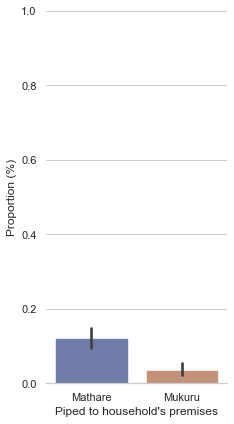

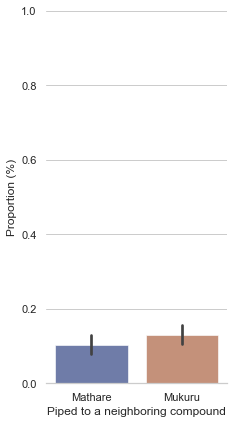

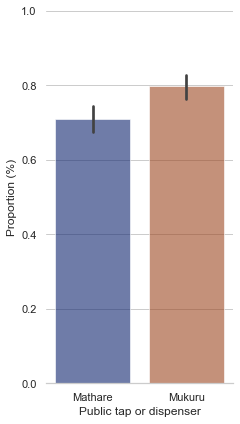

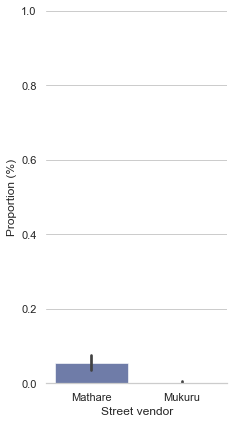

In [15]:
## Nested barplot by water system and site

# Dummy dataframe
df_g = df.copy()

# Plot
list_y_vars = ['PipedWt','PipNbWt',
               'PbTapWt','StVenWt']
list_y_vars_names = ["Piped to household's premises","Piped to a neighboring compound",
                     "Public tap or dispenser","Street vendor"]
save_path = path.join(root_dir,
                      "txt/submission_4_AJTMH/v1_2_review/_figs/")
for y_var,y_name in zip(list_y_vars,list_y_vars_names):
    sns.set_theme(style="whitegrid")
    g = sns.catplot(
        data=df_g,
        kind="bar",
        x="Site", y=y_var, #hue="Site",
        palette="dark", alpha=.6, 
        height=6, aspect=3.5/6)
    g.set(ylim=(0, 1))
    g.despine(left=True)
    g.set_axis_labels(y_name, "Proportion (%)")

# 5. Notes

- Among the different water distribution systems, the only ones that showed a significant association with constant delivery were the PUBLIC TAPS and STREET VENDORS. The higher availability of water from public dispensers and street vendors is certainly due to the flexibility and capilarity of such distribution systems, which can be mobile and available on demand. On the contrary, piped water was not at all a guarantee of service continuity. However, as shown in Notebook 1a, only water from public taps was associated with lower levels of diarrhea. There is a balance to be found between safety and availability, and public water dispensers certainly have the potential to do so - by stocking water in such a way that it is available during shortages in the piped distribution system.  

- OVERCROWDING was significantly associated with lack of water (even adjusting by socioeconomic variables) - which can be explained by an intensive demand faced with an insufficient offer of water.  

- JMP service ladder: our results suggest that 'basic' water sources are not necessarily reliable in terms of service continuity (water availability, shown in step 3.1 above). This confirms the necessity of indicators of both safety and availability of water in the ladder, as it is the case in the "safely managed" category - which determines the SDG indicator 6.1.1. Of relevance, 'conventional' infrastructures (e.g., water piped to premises) were not significantly associated with service continuity. In fact, households using water from public taps, dispensers or street vendors were more likely to have constant access to water.  

- Also, as a recent study showed (https://doi.org/10.1016/S2214-109X(19)30268-2), the sole availability of improved water infrastructures does not necessarily impact on hygiene behaviour - which may depend as much on education and sensitiation than on the presence of basic services.